In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
#import fbprophet
#from fbprophet import Prophet
from datetime import date,timedelta

df = pd.read_csv('covid_us.csv')
df.drop(labels = "Unnamed: 0", axis = 1, inplace = True)

plt.rcParams['figure.figsize']=(12,6)
plt.style.use('ggplot')

In [2]:
df_American_Samoa = df[df['subregion1_name'] == 'American Samoa'].index.tolist()
df_District_of_Columbia = df[df['subregion1_name'] == 'District of Columbia'].index.tolist()
df_Guam = df[df['subregion1_name'] == 'Guam'].index.tolist()
df_Northern_Mariana_Islands = df[df['subregion1_name'] == 'Northern Mariana Islands'].index.tolist()
df_Puerto_Rico = df[df['subregion1_name'] == 'Puerto Rico'].index.tolist()
df_Virgin_Islands = df[df['subregion1_name'] == 'Virgin Islands'].index.tolist()
df.drop(df_American_Samoa, inplace = True)
df.drop(df_District_of_Columbia, inplace = True)
df.drop(df_Guam, inplace = True)
df.drop(df_Northern_Mariana_Islands, inplace = True)
df.drop(df_Puerto_Rico, inplace = True)
df.drop(df_Virgin_Islands, inplace = True)


#remove all subregion1_name not in 50 states

In [3]:
x = sorted(df['subregion1_name'].unique())
d = {'states' : x}
us_states = pd.DataFrame(data = d)

df = df.sort_values(['subregion1_name', 'date'])
df.reset_index(inplace = True)

#df.dtypes

In [4]:
df = df.fillna(0)                                               #replace all columns with NA in df to 0


#df['total_tested'] = df['total_tested'].fillna(0) 
df['total_confirmed'] = df['total_confirmed'].astype(np.int64)



In [5]:
new_date = []
for i in range(df.shape[0]):
    new_date.append(int("".join(df.loc[i, 'date'].split('-'))))
new_date
df['new_date'] = new_date

#df.head()
#df.dtypes

In [6]:
i = 1
ndays = []
for n in range(df.shape[0]):
    if i == 483:
        i = 1
        ndays.append(i)
        i +=1
    else: 
        ndays.append(i)
        i += 1
df['ndays'] = ndays
#df['date'] = pd.to_datetime(df['date'])



In [7]:
states_by_indices = []
i = 0

for n in range(df.shape[0]):
    if df.loc[n, 'subregion1_name'] == us_states.loc[i, 'states']:
        states_by_indices.append(i)
    else:
        i += 1
        states_by_indices.append(i)
        
states_by_indices


dict = {}
for i in us_states['states']:
    dict["df_{0}".format(i)] = df[df['subregion1_name'] == i]            #store the df_states inside a dictionary
                                                                         #key is df_states, value is the dataframe associated with that state
#dict["df_West Virginia"]                                                 #example: dict["df_West Virginia"] gets the dataframe for all rows with subregion1_name = West Virginia 

for key in dict:
    dict[key] = dict[key].reset_index()                                  #reset the index of df_states for easier manipulation of data

In [8]:
class LinearRegression:
    def __init__(self):
        self.b = []
        self.X = []     
        return      
    
    def fit(self, x, y, order): 
        
        self.index = 0
        
        self.X = np.c_[np.ones(len(x))]   #initialize X as a matrix having columns of ones. This corresponds to polynomial of order 0
        while True:
            if self.index < order and order != 0:                          #concatenate power of x to original matrices X
                self.index += 1
                self.X = np.c_[self.X, np.power(x, self.index)]
            
            else:
                break
        self.b = np.linalg.inv(self.X.T@self.X)@(self.X.T@y)           # w = (X^T*X)^-1*(X^T*y) Formula given in lecture
        
        
        return self.X, self.b
    
    def predict(self):
        
        predict_array = self.X@self.b                  #prediction array is just X*w
        
        return predict_array
    
    def mse(self, y, predict_array):
        
        self.mse_array = y - predict_array
        
        self.mse = np.power(self.mse_array, 2)
        
        return np.sum(self.mse)/len(y)

In [9]:
def FitOrder(x,y):                                                #optimization for finding the order that corresponds with minimum mse
    new_order = []
    for i in range(310):
        linear = LinearRegression()
        linear.fit(x,y,i)
        prediction = linear.predict()
        new_order.append(linear.mse(y,prediction))
    index_order = new_order.index(min(new_order))
    return index_order

In [10]:
def StateLinearRegression(state, input_col, start_day, end_day):
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    
    for i in list(df.columns):
        if i == input_col:
            y = np.array(df_state[i][start_day:end_day+1])
            break
    #y = np.array(df_state['total_confirmed'][:480])
    order = FitOrder(x,y)                                                                            #Used 400 samples as training set
    model = LinearRegression()
    model.fit(x,y,order)                                                                         
    n = model.predict()
    b = model.mse(y, n)
    
    plt.rcParams['figure.figsize'] = (12,6)
    plt.scatter(x,y, s = 5, color = 'tab:blue')
    plt.plot(x,n, color = 'r')
    plt.ticklabel_format(style = 'plain')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.xlabel('Days')
    plt.ylabel(input_col)
    plt.title("{} Covid-19 Cases".format(state))
    plt.show()
    
    return b, order
    

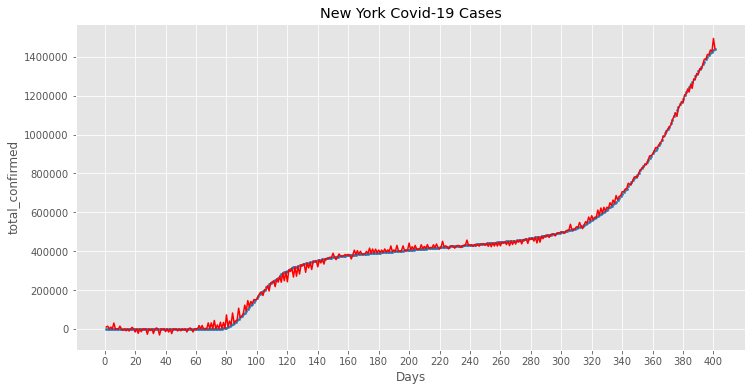

In [11]:
hello = StateLinearRegression("New York", 'total_confirmed', 0, 400)

In [12]:
print("The Mean Square Error is", hello[0], 'and the order of fit is', hello[1])

The Mean Square Error is 226285518.0419846 and the order of fit is 261


In [13]:
def PlotBar(state, input_col, start_day, end_day):
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    y = np.array(df_state[input_col][start_day:end_day+1])
        
    plt.rcParams['figure.figsize'] = (12,6)
    plt.bar(list(x), list(y), color='tab:blue')
    plt.xticks(np.arange(0, max(x)+1, 20))
    plt.xlabel('Days', size = 10)
    plt.ylabel(input_col, size = 10)
    plt.title("{0}'s Bar plot of Days vs {1}".format(state, input_col), size = 10)
    plt.show()
    

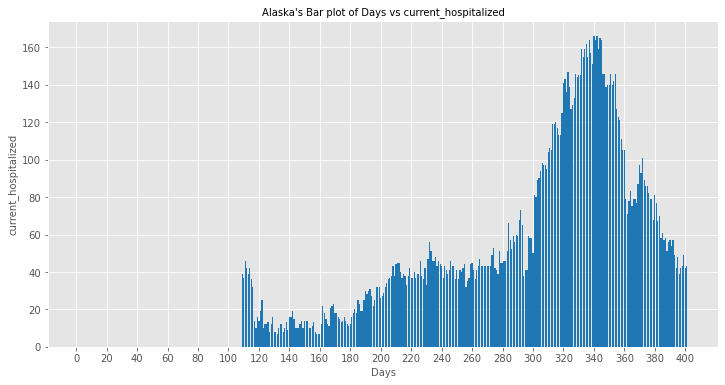

In [14]:
PlotBar("Alaska", 'current_hospitalized', 1, 400)

In [15]:
def BarAndRegression(state, input_col, start_day, end_day):
    PlotBar(state, input_col, start_day, end_day)
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    x = np.array(df_state['ndays'][start_day:end_day+1])
    y = np.array(df_state[input_col][start_day:end_day+1])
    
    order = FitOrder(x,y)
    model = LinearRegression()
    model.fit(x,y,order)                                                                         
    n = model.predict()
    plt.plot(x,n, color = 'r')
    plt.title("{0}'s Bar plot and Regression of Days vs {1}".format(state, input_col), size = 10)
    plt.show()

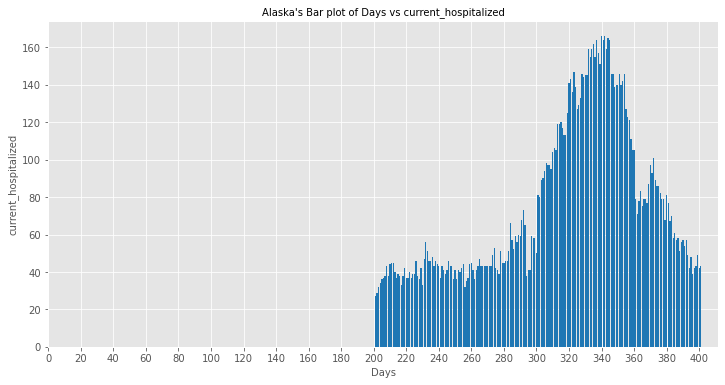

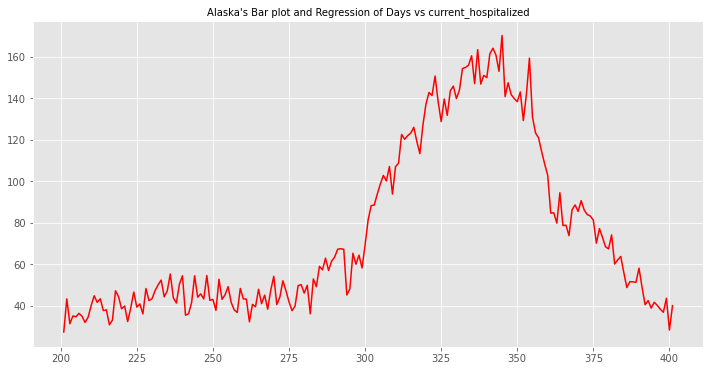

In [16]:
 BarAndRegression("Alaska", 'current_hospitalized', 200, 400)

In [17]:
def Stateinfo(state, day):                                         #Display the info at a specific state and day
    for key in dict:
        if dict[key]['subregion1_name'][0] == state:
            df_state = dict[key]
            break
    df_new = df_state[df_state['ndays']==day ]
    #df_new = pd.DataFrame.transpose(df_new)
    df_new = df_new.T
    df_new.rename({day-1:state}, axis = 1, inplace = True) 
    
    df_new.drop('level_0', inplace = True)
    df_new.drop('country_name', inplace = True)
    df_new.drop('index', inplace = True)
    df_new.drop('new_date', inplace = True)
    df_new.drop('population_age_00_09', inplace = True)
    df_new.drop('population_age_10_19', inplace = True)
    df_new.drop('population_age_20_29', inplace = True)
    df_new.drop('population_age_30_39', inplace = True)
    df_new.drop('population_age_40_49', inplace = True)
    df_new.drop('population_age_50_59', inplace = True)
    df_new.drop('population_age_60_69', inplace = True)
    df_new.drop('population_age_70_79', inplace = True)
    df_new.drop('population_age_80_89', inplace = True)
    df_new.drop('population_age_90_99', inplace = True)
    df_new.drop('population_age_80_and_older', inplace = True)
    df_new.drop('locality_name', inplace = True)
    df_new.drop('subregion1_name', inplace = True)
    df_new.drop('population_male', inplace = True)
    df_new.drop('population_female', inplace = True)
    df_new = df_new[df_new[state]!=0]
    
    return df_new

In [18]:
 Stateinfo('New York', 100)

,New York
date,2020-04-09
new_confirmed,10621
new_deceased,799
new_tested,26396
total_confirmed,159937
total_deceased,7067
total_tested,391549
new_hospitalized,2870
total_hospitalized,42852
current_hospitalized,18279


In [19]:
#   Commented out--fbprophet is being difficult.
# 
#  class TimeSeriesForecast:
    
#     def __init__(self):    
        
#         self.viz_df =[]
#         self.last_date = []
#         self.df_state = []
#         self.prediction = []
#         self.forecast = []
#         self.state = []
#         self.input_col = []
        
#         return   
   
#     def Statepredict(self, state, input_col):
#         for key in dict:
#             if dict[key]['subregion1_name'][0] == state:
#                 self.df_state = dict[key]
#                 break
        
#         self.state = state
#         self.input_col = input_col
#         self.df_state = self.df_state = self.df_state[['date', input_col]]
#         self.df_state.columns = ['ds', 'y']
#         model = Prophet()
#         model.fit(self.df_state) 
#         future_dates = model.make_future_dataframe(periods = 100)          #adding 100 days/datetime to the dataframe
#         self.prediction = model.predict(future_dates)
#         self.df_state.set_index('ds', inplace=True)
#         self.last_date = self.df_state.index[-1]
#         self.prediction.set_index('ds', inplace=True)
#         self.df_table = self.df_state.join(self.prediction[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
    
#     def plot_data(self):
#         self.last_date = self.last_date - timedelta(weeks=4) 
#         forecast_index= (self.df_table.index > self.last_date) #  pull out the predicted/forecast rows of data.
#         self.forecast = self.df_table.loc[forecast_index]       # create a new dataframe with predicted/forecast data.
        
#         fig, ax1 = plt.subplots()
#         ax1.ticklabel_format(useOffset=False, style='plain')
#         ax1.plot(self.df_state.y[:453])
#         ax1.plot(self.prediction.yhat)
#         ax1.plot(self.forecast.yhat, color='purple')
        
#         ax1.fill_between(self.forecast.index, self.forecast['yhat_upper'], self.forecast['yhat_lower'], alpha=0.5, color='darkgrey')
        
#         ax1.set_ylabel(self.input_col)
#         ax1.set_xlabel('Date')
#         ax1.set_title("{0}: Datetime vs {1} forecast plot".format(self.state, self.input_col))
#         ax1.legend(['original data', 'prediction', 'forecast']) 
    

In [20]:
# def CallTimeSeriesForecast(state, input_col):
#     mod = TimeSeriesForecast()
#     mod.Statepredict(state, input_col)
#     mod.plot_data()
#     return mod.prediction

In [21]:
# model = CallTimeSeriesForecast('New York', 'total_confirmed')

In [22]:
# ARIMA Forecasting

df = df.set_index('date')
df= df.drop(columns = 'index')
df.head()

,country_name,subregion1_name,locality_name,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,...,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_89,population_age_90_99,population_age_80_and_older,new_date,ndays
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200101,1
2020-01-02,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200102,2
2020-01-03,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200103,3
2020-01-04,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200104,4
2020-01-05,United States of America,Alabama,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,680141.0,613936.0,666838.0,645125.0,414601.0,150889.0,37722.0,188612.0,20200105,5


In [23]:
#function for creating a dataframe for a specific state (with date as index)
def createStateDF(state):
  df_state = df[df["subregion1_name"] == state]
  return df_state

In [24]:
df_california = createStateDF("California")

In [25]:
#testing for stationarity
from statsmodels.tsa.stattools import adfuller
def stationarityTest(state, input): 
  df_test_state = createStateDF(state)
  series_test_stationarity = df_test_state[input]
  stationaritytest = adfuller(series_test_stationarity, autolag = 'AIC')
  print('Augmented Dickey-Fuller Statistic: %f' % stationaritytest[0])  
  print('p-value: %f' % stationaritytest[1])  
  # null hypothesis testing
  if(stationaritytest[1] < .05):
    print("Data is stationary!")
  else: 
    print("Data is not stationary!")
  df_test_plot = df_test_state[[input]]
  df_test_plot.plot()

Augmented Dickey-Fuller Statistic: -2.197983
p-value: 0.206978
Data is not stationary!


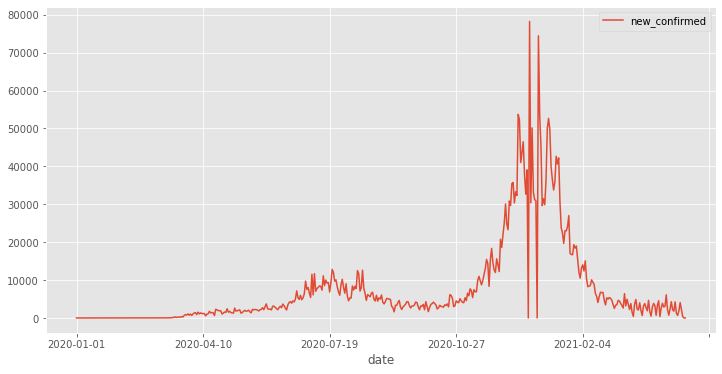

In [26]:
stationarityTest('California', 'new_confirmed')
# Data is not stationary--this should be taken care of in the third 'd' parameter in the ARIMA model.

In [27]:
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error


# This is all code from the Google colab. I kept it in for the moment.

X = df_california['new_confirmed'].tolist()
size = int(len(X) * 0.66)

train, test = X[0:size], X[size:len(X)]
stepwise_fit = auto_arima(df_california['total_confirmed'])           # set to stepwise
stepwise_fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  482
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6477.383
Date:                Sat, 22 May 2021   AIC                          12956.766
Time:                        21:40:19   BIC                          12960.942
Sample:                             0   HQIC                         12958.407
                                - 482                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.907e+10   1.22e+08    239.076      0.000    2.88e+10    2.93e+10
===================================================================================
Ljung-Box (Q):                        0.35   Jarque-Bera (JB):           4490433.21
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):           52000.03   Skew:                           -21.70
Prob(H) (two-sided):                  0.00   Kurtosis:                       474.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

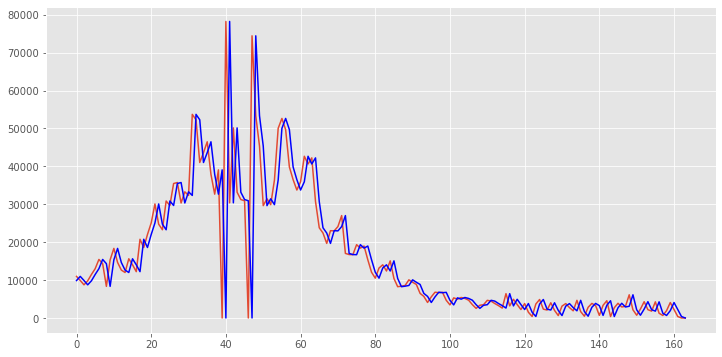

In [28]:
# stepwise_fit.plot_diagnostics(figsize=(7,5))
# plt.show()

# model = ARIMA(df_california['new_confirmed'], order=(0,1,0))
# model_fit = model.fit()
# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()

X = df_california['new_confirmed'].tolist()
size = int(len(X) * 0.66)

history = [x for x in train]
predictions = list()

for t in range(len(test)):
  model = ARIMA(history, order=(0,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='blue')
pyplot.show()

In [29]:
def createStateDF(state):
        df_state = df[df["subregion1_name"] == state]
        return df_state

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
class ARIMAForecast:
    def __init__(self, state, input_col):
    
        self.df_state = createStateDF(state)
        self.input_col = input_col
        self.prediction = 0
        self.fc = []
        # accuracy metrics
        self.me = []
        self.mae = []
        self.rmse = []
        self.corr = []
        self.mins = []
        self.maxs = []
        return

    #function for creating a dataframe for a specific state (with date as index)
    
    def forecast_accuracy(self, forecast, actual):
        self.me = np.mean(forecast - actual)             # ME
        self.mae = np.mean(np.abs(forecast - actual))    # MAE
        self.rmse = np.mean((forecast - actual)**2)**.5  # RMSE
        self.corr = np.corrcoef(forecast, actual)[0,1]   # corr
        self.mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
        self.maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
        print("Mean Error :", self.me)
        print("Mean Absolute Error: ", self.mae)
        print("Root Mean Squared Error: ", self.rmse)
        print("Correlation between the Actual and the Forecast: ", self.corr)

    def buildForecast(self):
        if((self.df_state[self.input_col] == 0).all()):
            print("Sorry, this state has no values from", self.input_col)
            return
        model = pm.auto_arima(self.df_state[self.input_col], start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=3, max_q=3, # maximum p and q
                        m=1,              # frequency of series
                        max_d=3,          
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
        # c = 0
        # self.df_state[self.input_col].plot()

        if(model.order[1] > 2):
            print("To make stationary, number of transformations must be greater than 0--not supported with current ARIMA class building.")
            return
            # Beginning attempts to make stationary--not implemented yet.
            # self.df_state['log'] = np.log(self.df_state[self.input_col])
            # self.df_state['log_diff'] = self.df_state['log'] - self.df_state['log'].shift(1)
            # self.df_state['log_diff'].plot()
            # self.df_state['diff'] = self.df_state[self.input_col] - self.df_state[self.input_col].shift(1)
            # self.df_state['diff'].plot()
            # #order=[model.order[0],2,model.order[2]]
            # c=1
            # model = pm.auto_arima(self.df_state['diff'], start_p=1, start_q=1,
            #             test='adf',       # use adftest to find optimal 'd'
            #             max_p=3, max_q=3, # maximum p and q
            #             m=1,              # frequency of series
            #             max_d=3,          
            #             seasonal=False,   # No Seasonality
            #             start_P=0, 
            #             D=0, 
            #             trace=True,
            #             error_action='ignore',  
            #             suppress_warnings=True, 
            #             stepwise=True)
            # order=model.order
        else:
            order=model.order
        model = ARIMA(self.df_state[self.input_col], order=order)
        print(order)
        model_fit = model.fit(disp=0)
        # if(c==0):
        #     model_fit = model.fit(disp=0) #fits ARIMA by exact maximum likelihood
        # else:

        # Plot forecast from all data (no training/test split involved)
        model_fit.plot_predict(end=date.today(),dynamic=False)
        plt.show()

        # I need to drop 0s from fc to get the percent erros and such--for the moment they are cut

        self.prediction = model_fit.predict(start=model_fit.fittedvalues.index[0], end=date.today(), typ = 'levels').values[0]
        self.fc = model_fit.predict(start=model_fit.fittedvalues.index[0], end=model_fit.fittedvalues.index[-1], typ = 'levels').values

        # Accuracy estimates, input forecast and the actual data starting from the first date which the fitted values start at
        self.forecast_accuracy(self.fc, self.df_state[self.input_col][model_fit.fittedvalues.index[0]:])

        # Print out final prediction
        print("Final estimate on ", date.today(), " is: ",  self.prediction)

In [126]:
def CallARIMAForecast(state, input_col):
    mod = ARIMAForecast(state, input_col)
    mod.buildForecast()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9564.682, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9820.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9619.179, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9573.244, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9818.879, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9561.283, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9607.047, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9553.640, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9598.417, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9483.029, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9560.026, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9531.389, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9530.407, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=9481.015, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0]          

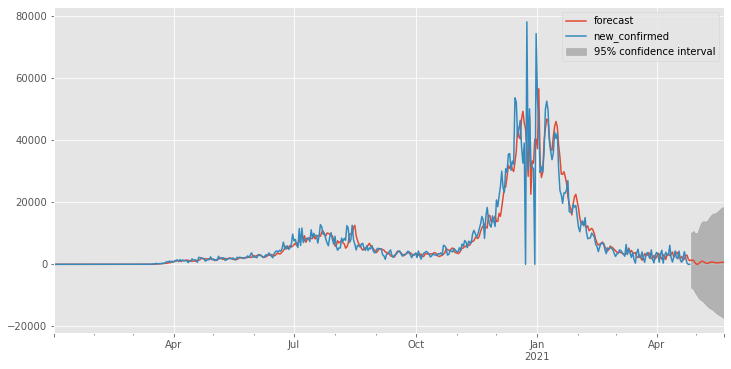

Mean Error : -3.376910476663245
Mean Absolute Error:  1750.4166346087077
Root Mean Squared Error:  4548.914710252913
Correlation between the Actual and the Forecast:  0.9184625616958308
Final estimate on  2021-05-22  is:  0.001243853464953817


In [100]:
CallARIMAForecast("California", 'new_confirmed')

In [134]:
CallARIMAForecast("California", "total_confirmed")

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=12914.912, Time=0.19 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=13672.056, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=12911.969, Time=0.71 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=12912.723, Time=0.82 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=12910.995, Time=0.73 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=12912.567, Time=0.47 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=12914.317, Time=0.86 sec
 ARIMA(2,3,3)(0,0,0)[0]             : AIC=12913.014, Time=0.93 sec
 ARIMA(1,3,3)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(3,3,3)(0,0,0)[0]             : AIC=12915.004, Time=0.98 sec
 ARIMA(2,3,2)(0,0,0)[0] intercept   : AIC=12918.393, Time=0.81 sec

Best model:  ARIMA(2,3,2)(0,0,0)[0]       

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9564.682, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9820.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9619.179, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9573.244, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9818.879, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9561.283, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9607.047, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9553.640, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9598.417, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9483.029, Time=0.46 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9560.026, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9531.389, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9530.407, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=9481.015, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0]          

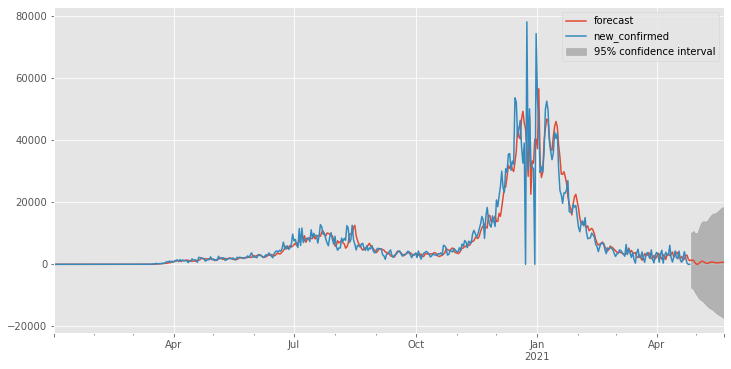

Mean Error : -3.376910476663245
Mean Absolute Error:  1750.4166346087077
Root Mean Squared Error:  4548.914710252913
Correlation between the Actual and the Forecast:  0.9184625616958308
Final estimate on  2021-05-22  is:  0.001243853464953817


In [105]:
CallARIMAForecast("California", "new_confirmed")

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6025.122, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6242.994, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6161.898, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6029.576, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6240.994, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6025.027, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6137.697, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6013.886, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6121.111, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5993.001, Time=0.87 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6027.332, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5927.887, Time=1.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6002.081, Time=0.89 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=5926.389, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0]          

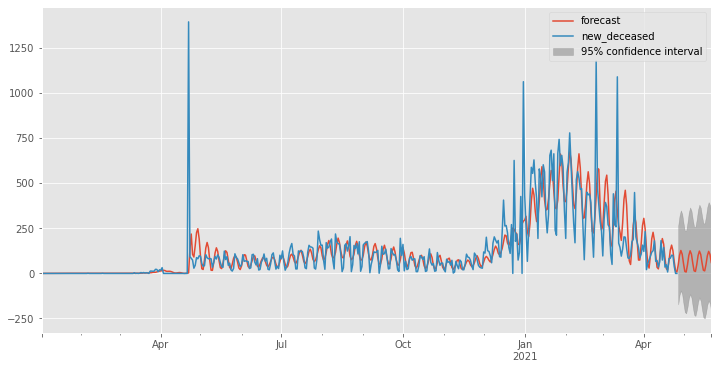

Mean Error : 0.017090872770769115
Mean Absolute Error:  50.02619913062505
Root Mean Squared Error:  111.53185158506247
Correlation between the Actual and the Forecast:  0.7871289289152779
Final estimate on  2021-05-22  is:  0.13599716301120082


In [129]:
CallARIMAForecast("California", "new_deceased")

In [131]:
CallARIMAForecast("California", "new_recovered")

Sorry, this state has no values from new_recovered


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11986.540, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12190.003, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12128.766, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11991.378, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12188.004, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11975.328, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12056.873, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11977.295, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11970.673, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11969.230, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11976.286, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11965.145, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11967.094, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11966.350, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0

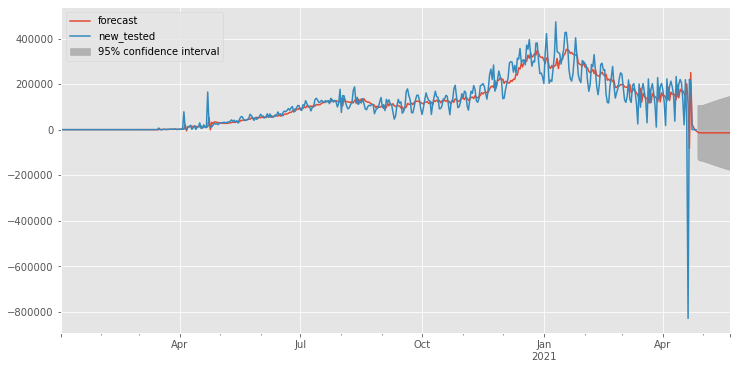

Mean Error : 146.23597105049282
Mean Absolute Error:  27323.211860830623
Root Mean Squared Error:  60042.89621958753
Correlation between the Actual and the Forecast:  0.8421707661191973
Final estimate on  2021-05-22  is:  0.0001260917835238189


In [108]:
CallARIMAForecast("California", "new_tested")

In [135]:
CallARIMAForecast("California", "total_deceased")

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=8976.124, Time=0.15 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=9739.281, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=8976.844, Time=0.59 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=8976.878, Time=0.53 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=8978.725, Time=0.64 sec
 ARIMA(1,3,1)(0,0,0)[0] intercept   : AIC=8977.026, Time=0.31 sec

Best model:  ARIMA(1,3,1)(0,0,0)[0]          
Total fit time: 2.981 seconds
To make stationary, number of transformations must be greater than 0--not supported with current ARIMA class building.


In [136]:
CallARIMAForecast("California", "total_recovered")

Sorry, this state has no values from total_recovered


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=15399.964, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=15710.296, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=15574.482, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=15398.691, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=15708.300, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=15408.851, Time=0.61 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=15386.312, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=15386.989, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=15382.288, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=15383.757, Time=0.28 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=15383.840, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=15385.751, Time=0.37 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 2.619 seconds
(0, 2, 2)
C:\Us

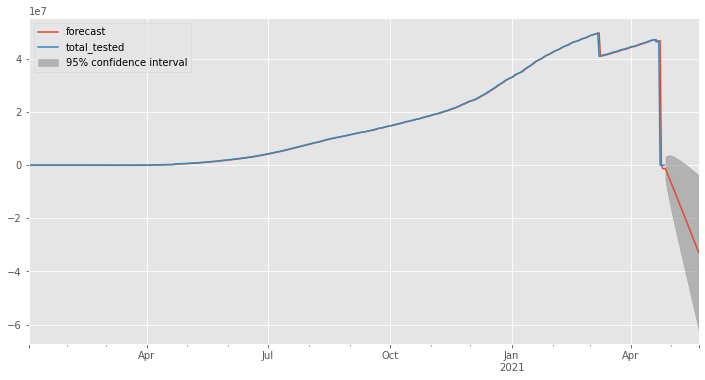

Mean Error : 9796.07220207533
Mean Absolute Error:  227016.67961396123
Root Mean Squared Error:  2180244.3974137576
Correlation between the Actual and the Forecast:  0.9917573954029723
Final estimate on  2021-05-22  is:  -2348.9058683953645


In [111]:
CallARIMAForecast("California", "total_tested")

In [137]:
CallARIMAForecast("California", "new_hospitalized")

Sorry, this state has no values from new_hospitalized


In [138]:
CallARIMAForecast("California", "total_hospitalized")

Sorry, this state has no values from total_hospitalized


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=6842.766, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=7150.849, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=7032.400, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=6844.030, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7148.849, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=6829.998, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=6919.171, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=6831.338, Time=0.38 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=6830.698, Time=0.48 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=6845.464, Time=0.37 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=6894.300, Time=0.09 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=6832.445, Time=0.88 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=6827.998, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=6840.766, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]          

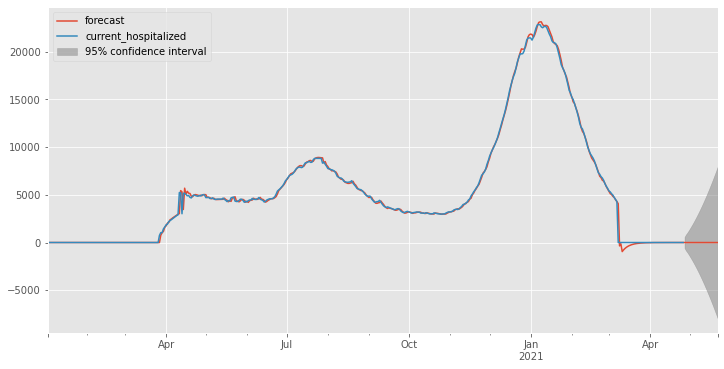

Mean Error : 0.0007314680426637851
Mean Absolute Error:  116.21518388889629
Root Mean Squared Error:  294.02744624366585
Correlation between the Actual and the Forecast:  0.998783298209418
Final estimate on  2021-05-22  is:  -9.71615936707684e-06


In [114]:
CallARIMAForecast("California", "current_hospitalized")

In [139]:
CallARIMAForecast("California", "new_intensive_care")

Sorry, this state has no values from new_intensive_care


In [140]:
CallARIMAForecast("California", "total_intensive_care")

Sorry, this state has no values from total_intensive_care


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5543.718, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5618.629, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5618.093, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5618.963, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5616.629, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5521.676, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5583.830, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5523.340, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5523.219, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5521.324, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5593.665, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5523.259, Time=0.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5586.295, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5525.120, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0]          

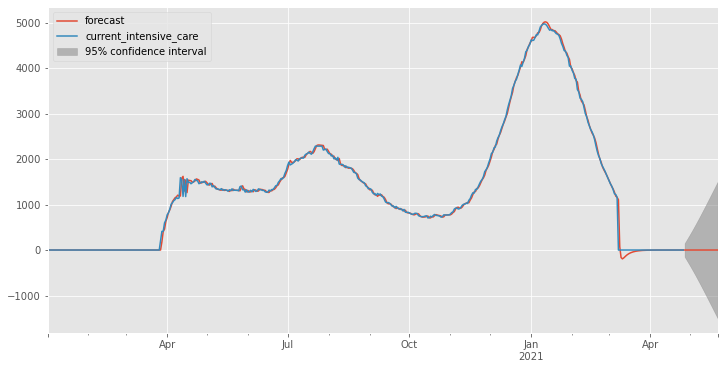

Mean Error : 0.00011814689713990523
Mean Absolute Error:  31.038150276965688
Root Mean Squared Error:  74.38691124773082
Correlation between the Actual and the Forecast:  0.9984436526817676
Final estimate on  2021-05-22  is:  -8.205217581343673e-06


In [141]:
CallARIMAForecast("California", "current_intensive_care")

In [142]:
CallARIMAForecast("California", "new_ventilator")

Sorry, this state has no values from new_ventilator


In [143]:
CallARIMAForecast("California", "total_ventilator")

Sorry, this state has no values from total_ventilator


In [144]:
CallARIMAForecast("California", "current_ventilator")

Sorry, this state has no values from current_ventilator


C:\Users\twin1\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:849: RuntimeWarning: divide by zero encountered in log
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:849: RuntimeWarning: invalid value encountered in double_scalars
  llf = -nobs / 2. * (log(2 * pi) + log(sigma2)) - ssr / (2 * sigma2)
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

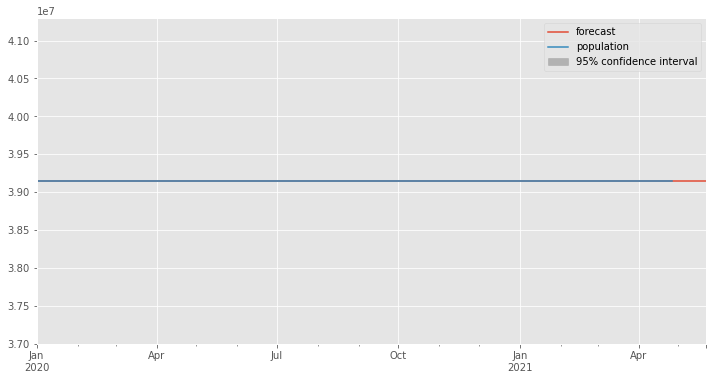

Mean Error : 0.0
Mean Absolute Error:  0.0
Root Mean Squared Error:  0.0
Correlation between the Actual and the Forecast:  nan
Final estimate on  2021-05-22  is:  39144818.0
C:\Users\twin1\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [146]:
CallARIMAForecast("California", "population")

C:\Users\twin1\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=17598.195, Time=0.01 sec
Total fit time: 0.011 seconds
(0, 0, 0)


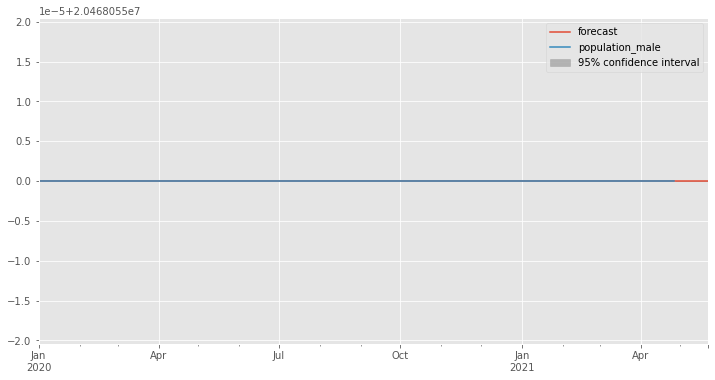

Mean Error : -3.725290298461914e-09
Mean Absolute Error:  3.725290298461914e-09
Root Mean Squared Error:  3.725290298461914e-09
Correlation between the Actual and the Forecast:  nan
Final estimate on  2021-05-22  is:  20468054.999999996
C:\Users\twin1\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [147]:
CallARIMAForecast("California", "population_male")

C:\Users\twin1\anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\twin1\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=17616.321, Time=0.01 sec
Total fit time: 0.013 seconds
(0, 0, 0)


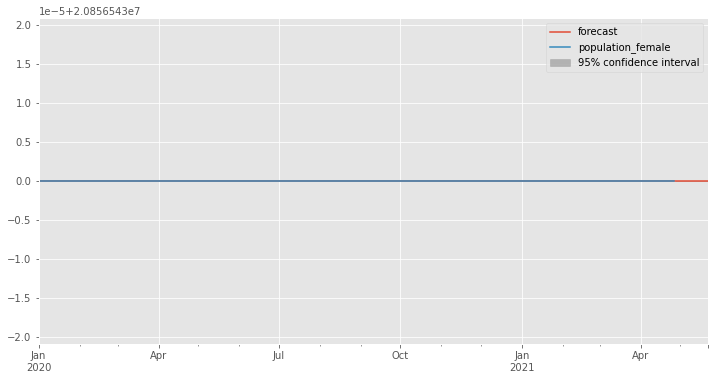

Mean Error : -3.725290298461914e-09
Mean Absolute Error:  3.725290298461914e-09
Root Mean Squared Error:  3.725290298461914e-09
Correlation between the Actual and the Forecast:  nan
Final estimate on  2021-05-22  is:  20856542.999999996
C:\Users\twin1\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


In [148]:
CallARIMAForecast("California", "population_female")